In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
from random import random as rand

## import mydef as my Class correction for projects
# import mydef

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
dir_script = '.'

dir_work = join('/mnt/sda2/GA')
dir_behav = dir_work + '/behav_data'
dir_fmri = dir_work + '/fmri_data'

In [4]:
list_subj = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15'
            ,'18', '19', '20', '21', '23', '26', '27', '28', '29', '30'
            ,'31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
list_stage = ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']

In [5]:
## labeling with target position
# 1 - 5 - 25 - 21 - 1 - 25 - 5 - 21 - 25 - 1 - 21 - 5 - 1 - ...
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []
with open(join(dir_script,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
target_pos = np.array(target_pos[1:97])
target_pos

array([ 5, 25, 21,  1, 25,  5, 21, 25,  1, 21,  5,  1,  5, 25, 21,  1, 25,
        5, 21, 25,  1, 21,  5,  1,  5, 25, 21,  1, 25,  5, 21, 25,  1, 21,
        5,  1,  5, 25, 21,  1, 25,  5, 21, 25,  1, 21,  5,  1,  5, 25, 21,
        1, 25,  5, 21, 25,  1, 21,  5,  1,  5, 25, 21,  1, 25,  5, 21, 25,
        1, 21,  5,  1,  5, 25, 21,  1, 25,  5, 21, 25,  1, 21,  5,  1,  5,
       25, 21,  1, 25,  5, 21, 25,  1, 21,  5,  1])

In [6]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [7]:
def calc_mrew(behav_datum):
    datum = scipy.io.loadmat(behav_datum)
    nS = int(datum['nSampleTrial'][0][0])
    sec_per_trial = 5  ## time spend(second) in each trial
    ntrial = 12
    nblock = 8
    #ttt = nblock*6 # total number of blocks = 8 blocks/run * 6 runs
    tpr = 97   ## 1 trial/run + 12 trials/block * 8 block/run
    nrun = 6

    targetID = datum['targetID'][0]
    targetID = targetID[targetID>0]
    ## targetID.shape = (679,) : 679 trials = 97 trials/run * 7 runs

    cnt_frame_hit = np.zeros((tpr*nrun,nS), dtype=bool)
    ## The 7th Run should be dropped. (582 trials = 97 trials/run * 6 runs)
    for t, ID in enumerate(targetID[:tpr*nrun]):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*t:nS*(t+1)] # allXY.shape = (2, 60 Hz * 5 s/trial * 97 trials/run * 7 runs = 203700 frames)
        err = xy - np.ones((2,nS))*pos.T     # err.shape = (2, nS)
        cnt_frame_hit[t,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)

    rew_bin = np.zeros((nrun,sec_per_trial*tpr))
    for r in range(nrun):
        temp = cnt_frame_hit[tpr*r:tpr*(r+1),:].reshape(nS*tpr,1)
        for i in range(sec_per_trial*tpr):
            rew_bin[r,i] = sum(temp[60*i:60*(i+1)])

    max_score =  nS*ntrial   ## total frames in a block
    temp = rew_bin[:,sec_per_trial:].reshape(nrun*sec_per_trial*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[sec_per_trial*ntrial*i:sec_per_trial*ntrial*(i+1)])/max_score

    return norm_mrew

# Load data

1-1. A wide form

In [8]:
df = pd.DataFrame(columns=['block%02d'%(block+1) for block in range(48)], dtype='float64')

for subj in list_subj:
    for visit in ['early', 'late']:
        suffix = 'fmri' if visit=='early' else('refmri' if visit=='late' else 'invalid')
        subjID = 'GA'+subj if visit=='early' else('GB'+subj if visit=='late' else 'invalid')
        
        mrew = calc_mrew(dir_behav+'/GA%s-%s.mat'%(subj,suffix))
        for ii, rew in enumerate(mrew):
            df.loc[subjID, 'block%02d'%(ii+1)] = rew
df

,block01,block02,block03,block04,block05,block06,block07,block08,block09,block10,...,block39,block40,block41,block42,block43,block44,block45,block46,block47,block48
GA01,0.225833,0.221389,0.370833,0.316389,0.341389,0.389444,0.266667,0.379444,0.476389,0.397778,...,0.429167,0.430000,0.397500,0.405000,0.263889,0.265833,0.330000,0.223333,0.338611,0.304722
GB01,0.662500,0.800833,0.651667,0.809167,0.783333,0.798056,0.790556,0.819722,0.809167,0.791111,...,0.656944,0.726944,0.722222,0.710833,0.753611,0.740556,0.793056,0.739444,0.752778,0.798056
GA02,0.382778,0.487222,0.434722,0.219167,0.381111,0.498611,0.438333,0.391944,0.366389,0.410556,...,0.430000,0.453611,0.360000,0.458611,0.542222,0.489167,0.498611,0.498056,0.573889,0.533611
GB02,0.731944,0.796389,0.824444,0.787778,0.803056,0.785556,0.823889,0.828333,0.797500,0.803056,...,0.650278,0.663611,0.644722,0.693611,0.695556,0.707778,0.639167,0.614167,0.600278,0.750000
GA05,0.040556,0.402222,0.246389,0.094167,0.221667,0.204167,0.045000,0.206944,0.305833,0.326944,...,0.216111,0.394722,0.395556,0.446389,0.453333,0.299167,0.435556,0.452778,0.375833,0.531389
GB05,0.508333,0.633611,0.722778,0.629722,0.694444,0.652778,0.591111,0.624167,0.659167,0.788333,...,0.604444,0.731667,0.437222,0.591944,0.596389,0.559444,0.537222,0.596944,0.666111,0.648889
GA07,0.146389,0.240833,0.070000,0.192500,0.293056,0.286111,0.257222,0.196944,0.233889,0.232778,...,0.617778,0.565833,0.543333,0.374167,0.544167,0.540278,0.556667,0.598333,0.480278,0.527500
GB07,0.526944,0.752222,0.755000,0.723611,0.709167,0.725278,0.703889,0.732222,0.767778,0.738333,...,0.562500,0.564722,0.622222,0.666944,0.660556,0.635556,0.700278,0.702222,0.538611,0.631111
GA08,0.263889,0.233056,0.411667,0.432222,0.258056,0.673889,0.530833,0.488611,0.341389,0.526111,...,0.348056,0.330556,0.437778,0.467500,0.421111,0.240556,0.444167,0.460556,0.348889,0.489722
GB08,0.419444,0.646389,0.641389,0.565000,0.718056,0.665556,0.731944,0.596667,0.665833,0.691944,...,0.396111,0.429444,0.428611,0.417222,0.431111,0.430278,0.483611,0.430556,0.624444,0.513056


In [10]:
df.loc['GA01'].values

array([0.22583333, 0.22138889, 0.37083333, 0.31638889, 0.34138889,
       0.38944444, 0.26666667, 0.37944444, 0.47638889, 0.39777778,
       0.36472222, 0.36694444, 0.40777778, 0.39694444, 0.29638889,
       0.33055556, 0.35222222, 0.42527778, 0.33833333, 0.43138889,
       0.40611111, 0.35305556, 0.44055556, 0.51194444, 0.21472222,
       0.31305556, 0.35277778, 0.32305556, 0.31555556, 0.45777778,
       0.33555556, 0.29361111, 0.40333333, 0.38611111, 0.43833333,
       0.40277778, 0.465     , 0.54305556, 0.42916667, 0.43      ,
       0.3975    , 0.405     , 0.26388889, 0.26583333, 0.33      ,
       0.22333333, 0.33861111, 0.30472222])

In [13]:
# import pickle as pkl

# ## (2 days, 30 subjects, 48 blocks) 형태로 정리 후 저장
# performance = np.ones((2,30,48)) * np.nan
# for i, gg in enumerate(['GA', 'GB']):
#     for j, subj in enumerate(list_subj):
#         performance[i,j] = df.loc[gg+subj].values
        
# ## save
# with open(join(dir_behav,'RewardRate.pkl'), 'wb') as f:
#     pkl.dump(performance, f)

1-2. improvement in success rate (= GB-GA)

In [11]:
## 48 blocks = 8 blocks/run * 6 runs
imp = {}
for nn in list_subj:
    imp[nn] = np.array(df.loc['GB'+nn] - df.loc['GA'+nn], dtype='float')
imp.keys()

# import pickle as pkl
# ## save
# with open(join(dir_behav,'RewardRate_improvement.pkl'), 'wb') as f:
#     pkl.dump(imp, f)

# ## load
# tmp = pd.DataFrame.from_dict(imp, orient='index')
# tmp.to_csv(join(dir_behav, 'RewardRate_improvement.txt'), header=True, index=True)
# tmp

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
01,0.436667,0.579444,0.280833,0.492778,0.441944,0.408611,0.523889,0.440278,0.332778,0.393333,...,0.227778,0.296944,0.324722,0.305833,0.489722,0.474722,0.463056,0.516111,0.414167,0.493333
02,0.349167,0.309167,0.389722,0.568611,0.421944,0.286944,0.385556,0.436389,0.431111,0.392500,...,0.220278,0.210000,0.284722,0.235000,0.153333,0.218611,0.140556,0.116111,0.026389,0.216389
05,0.467778,0.231389,0.476389,0.535556,0.472778,0.448611,0.546111,0.417222,0.353333,0.461389,...,0.388333,0.336944,0.041667,0.145556,0.143056,0.260278,0.101667,0.144167,0.290278,0.117500
07,0.380556,0.511389,0.685000,0.531111,0.416111,0.439167,0.446667,0.535278,0.533889,0.505556,...,-0.055278,-0.001111,0.078889,0.292778,0.116389,0.095278,0.143611,0.103889,0.058333,0.103611
08,0.155556,0.413333,0.229722,0.132778,0.460000,-0.008333,0.201111,0.108056,0.324444,0.165833,...,0.048056,0.098889,-0.009167,-0.050278,0.010000,0.189722,0.039444,-0.030000,0.275556,0.023333
11,0.553889,0.446111,0.474167,0.436389,0.285000,0.345000,0.270278,0.438611,0.390000,0.425278,...,-0.042778,-0.077222,0.113611,-0.020000,0.138611,-0.033611,0.124167,0.069167,0.073611,0.006111
12,0.430556,0.542222,0.405278,0.249722,0.494722,0.508333,0.317500,0.338056,0.409722,0.468889,...,-0.152500,-0.136944,-0.046111,0.082222,-0.276667,-0.191389,0.019444,-0.120833,-0.009167,-0.032222
13,0.600000,0.472500,0.402778,0.498333,0.492222,0.428056,0.207222,0.362500,0.428889,0.387500,...,0.064167,-0.256389,0.076389,0.145556,0.135278,-0.042500,0.110556,0.015556,0.041389,0.008333
14,0.349722,0.474722,0.468333,0.497222,0.412500,0.536389,0.556667,0.621667,0.600000,0.586111,...,0.233611,0.345833,0.321389,0.345000,0.188611,0.284722,0.266389,0.248889,0.333889,0.355000
15,0.606667,0.477222,0.478056,0.556111,0.494722,0.582500,0.517500,0.525556,0.405556,0.365278,...,-0.211667,-0.357500,-0.124167,-0.106944,-0.150278,-0.084722,-0.107778,-0.094722,-0.223889,-0.075556


2. A long form

# Figures

1. Individual

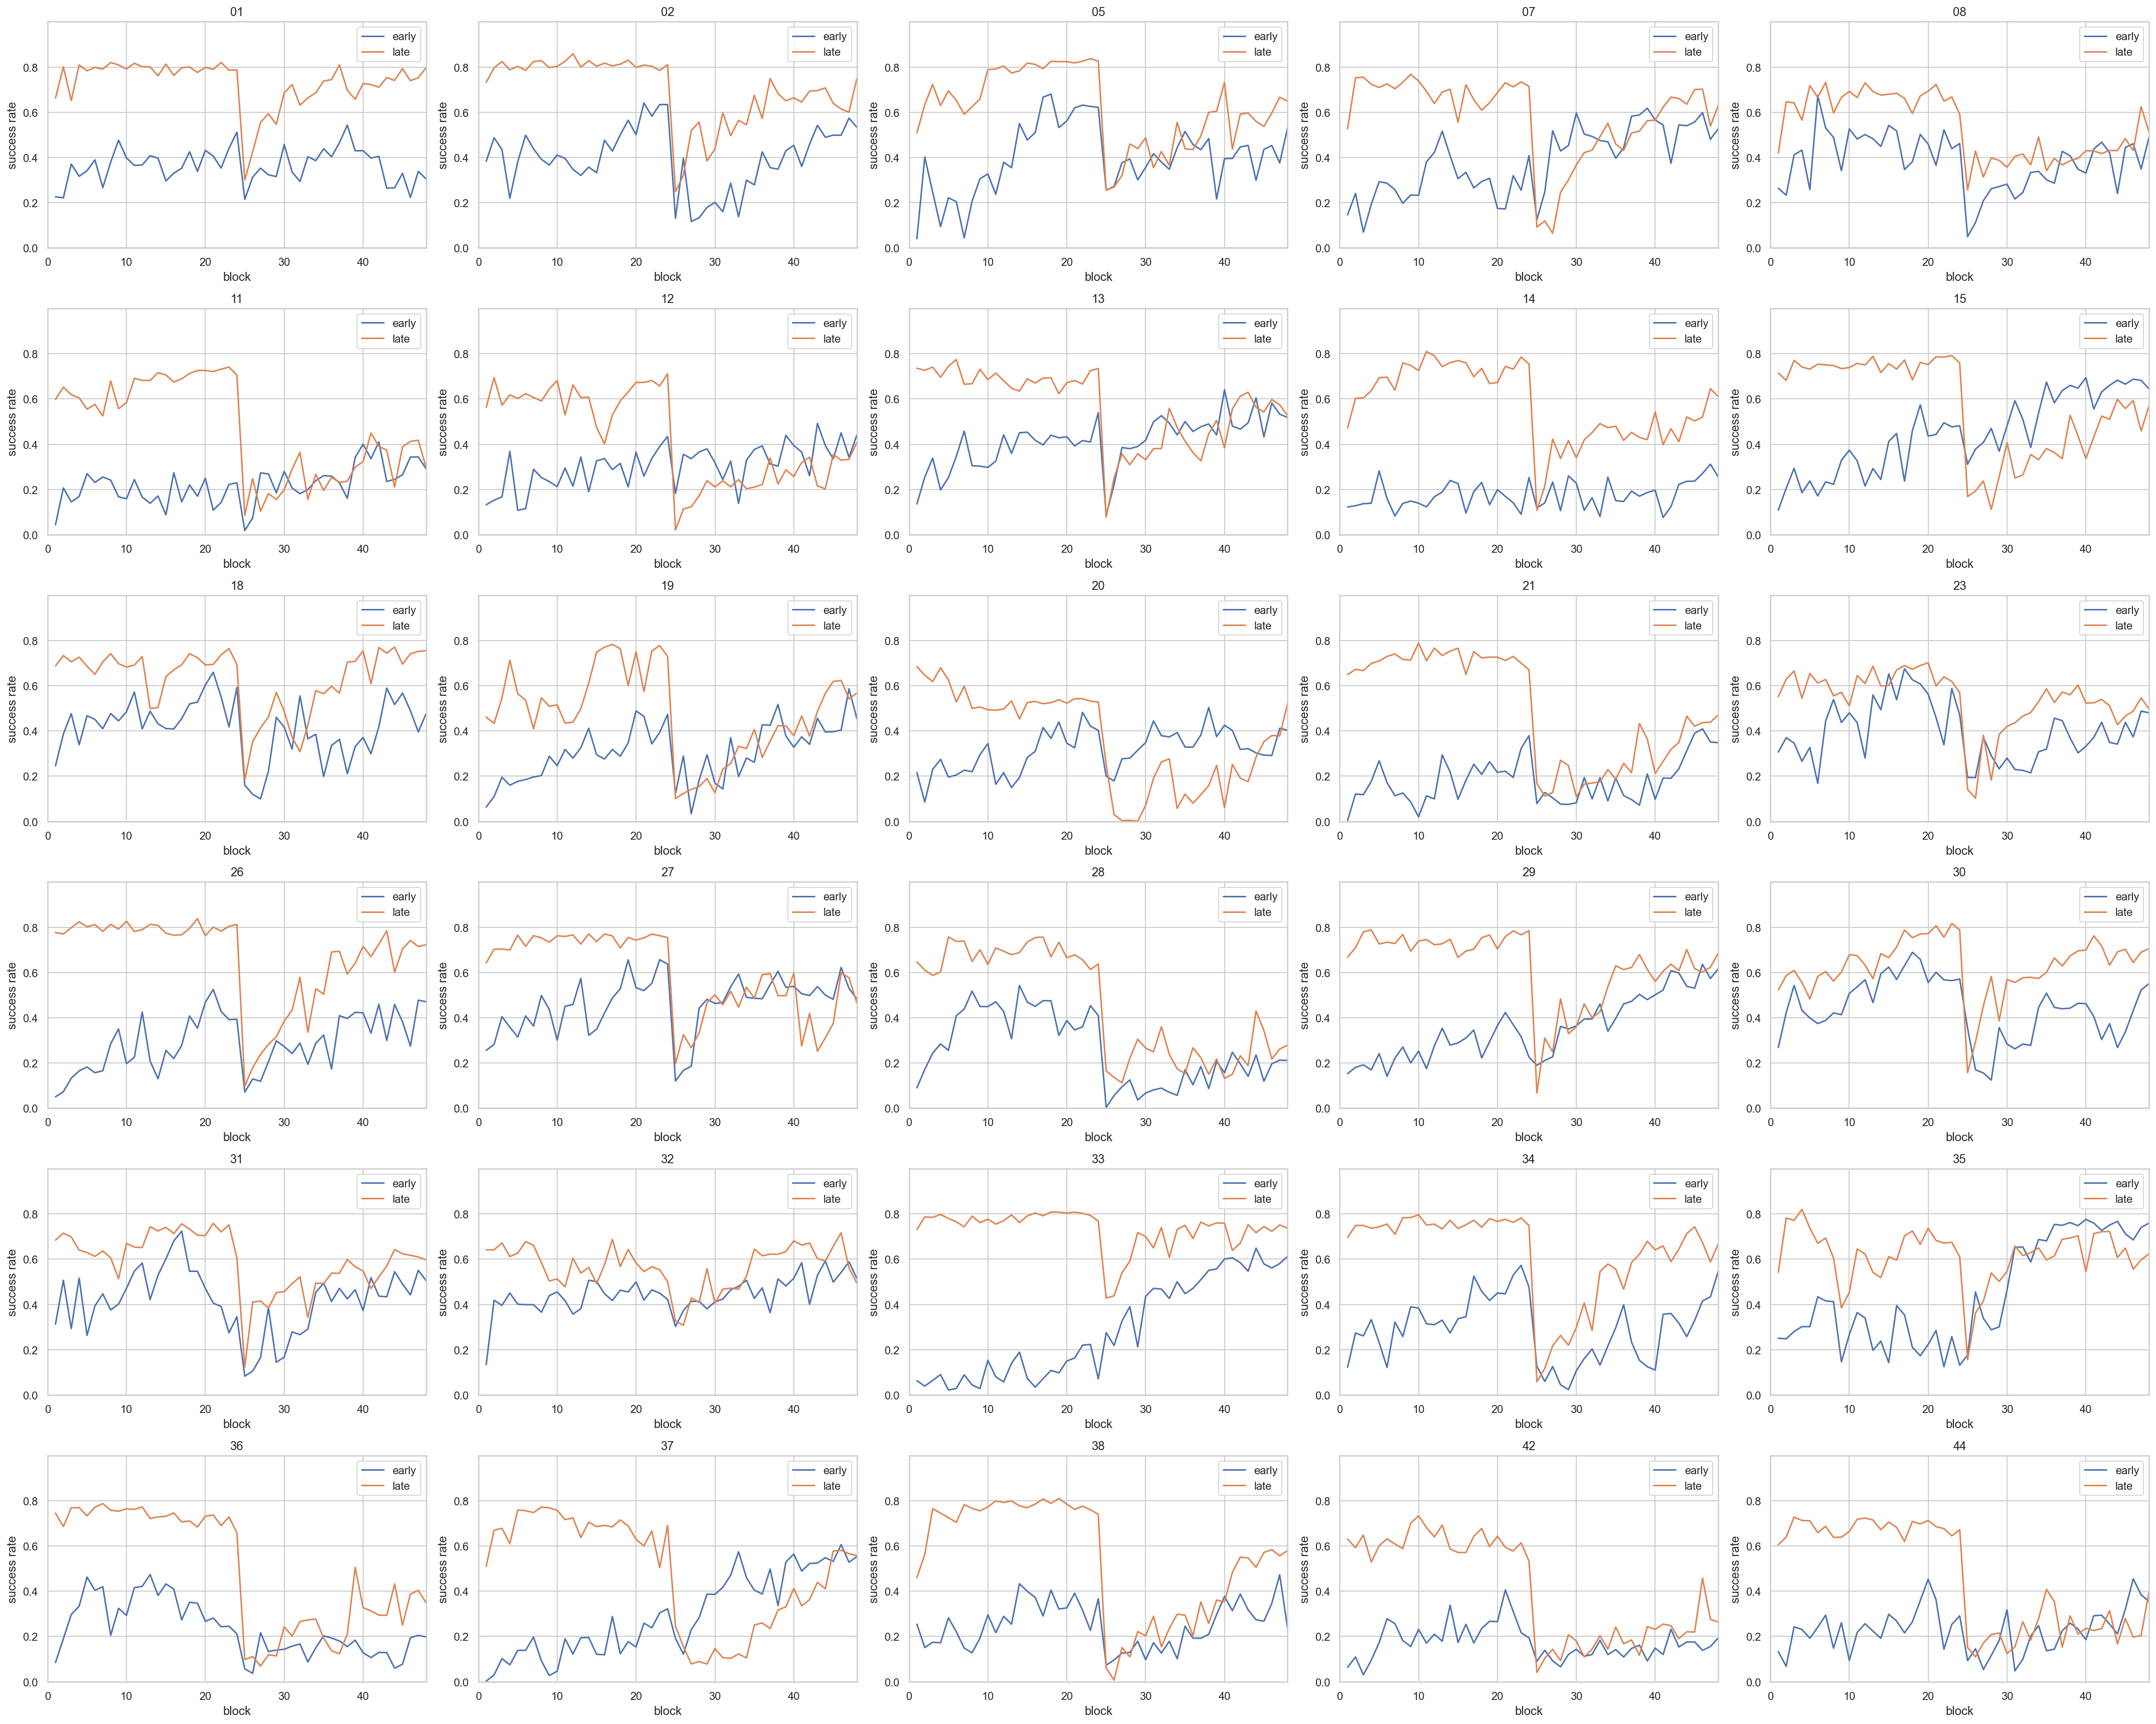

In [70]:
_, axes = plt.subplots(6,5,figsize=(30, 24))
axes = np.concatenate(axes)
sns.set_style('whitegrid')

for i, subj in enumerate(GA.list_subj):
    ax = sns.lineplot(x='block', y='reward', data=GA.df_rewards_long[GA.df_rewards_long.subj==subj], hue='visit', ax=axes[i])
    ax.set_title(subj)
    ax.set_xlim(0, 48)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0.,1.,.2))
    ax.set_ylabel('success rate', size=12)
    ax.legend(title='')
#     ax.get_legend().remove()
    plt.tight_layout()

2. Group

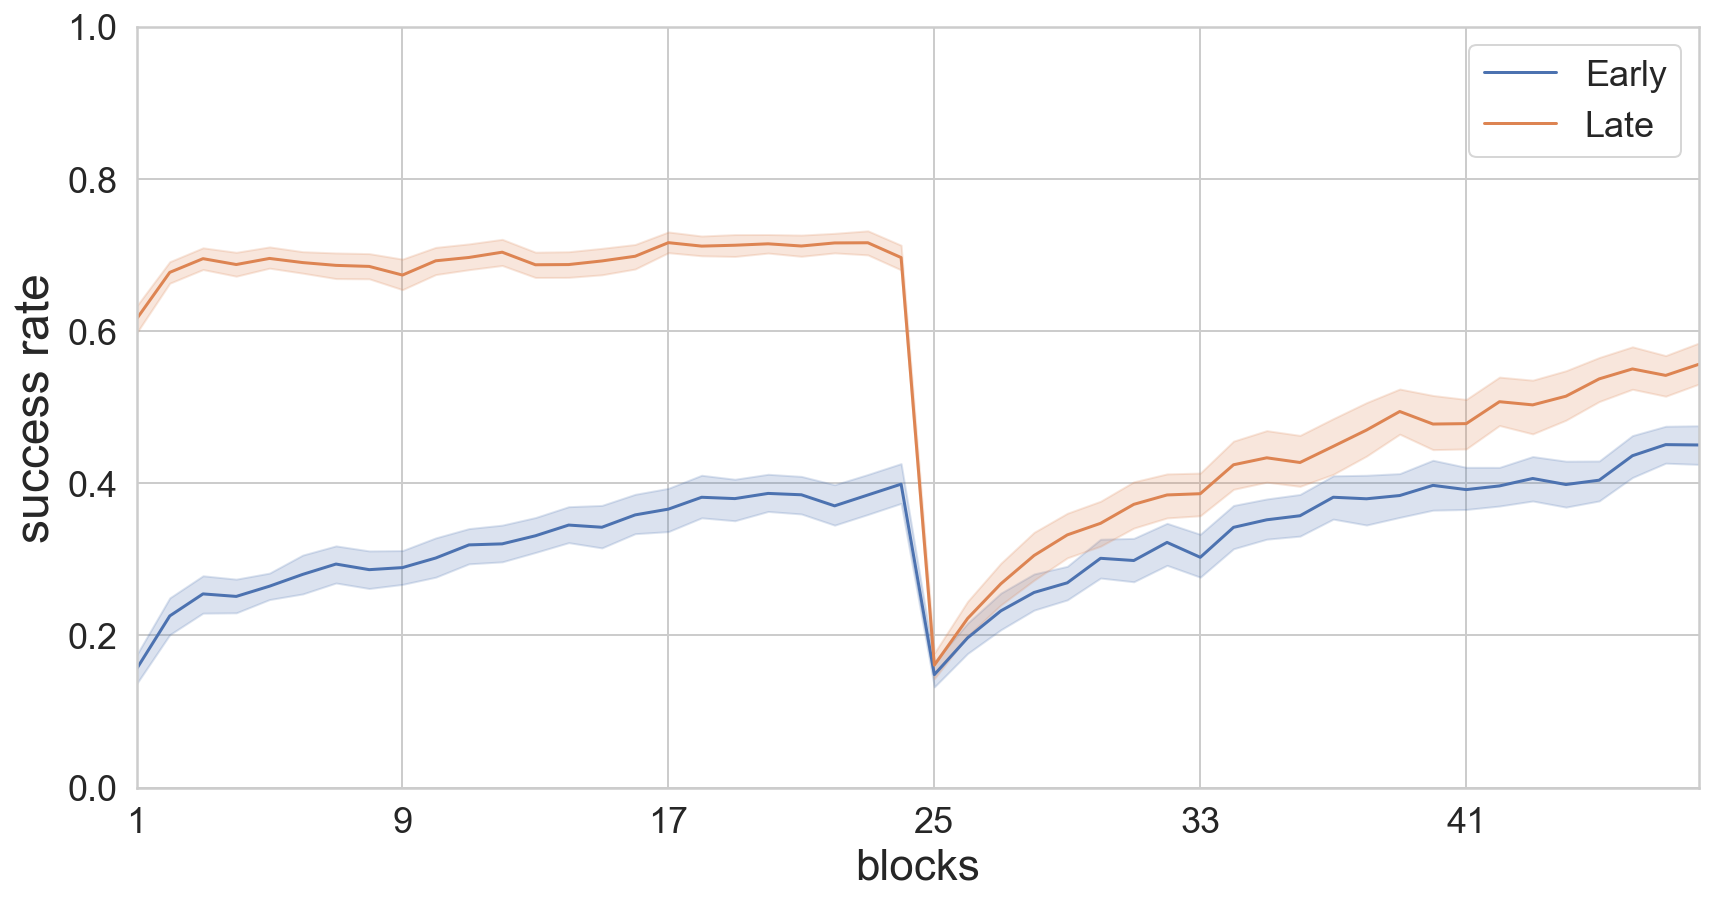

In [8]:
sns.set(style="whitegrid")

ax = plt.figure(figsize=(14, 7))
sns.lineplot(x='block', y='reward', data=GA.df_rewards_long, hue='visit', ci=100*GA.sig1)
plt.xlabel('blocks', size=22)
plt.ylabel('success rate', size=24)
plt.xticks(range(1,50,8),fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(1,48)
plt.ylim(0.,1.)
plt.legend(['Early','Late'], title=None, loc='best', fontsize=18)

3. boxplot

In [10]:
## grouby mean
temp = GA.df_rewards_long[GA.df_rewards_long['block']<=24].groupby(['subj','visit']).mean()
## reset indices
temp.reset_index(inplace=True)
## delete 'block' column
del temp['block']

Text(0, 0.5, 'Mean Reward Rate')

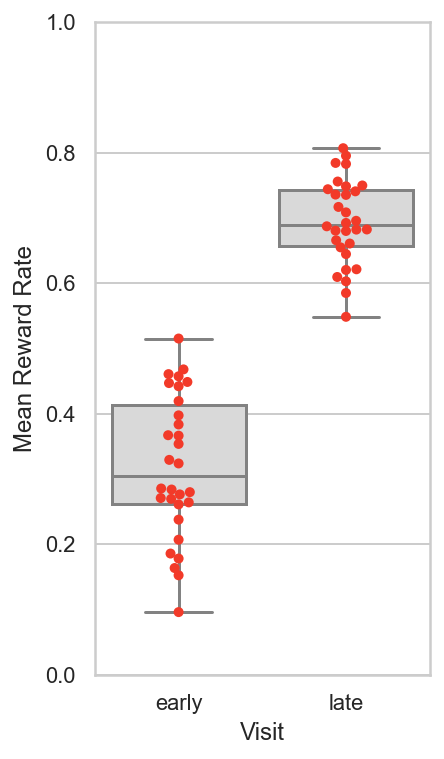

In [11]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.boxplot(x='visit', y='reward', data=temp, palette=["#D9D9D9"])
sns.swarmplot(x='visit', y='reward', data=temp, size=5, color="#F23A29", linewidth=0)

ax.set_ylim(0., 1.)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_xlabel('Visit')
ax.set_ylabel('Mean Reward Rate')
    
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# fig.savefig(fname=today+'_behav2.png', dpi=300)

- t-test

In [23]:
## t-test
A = temp[temp.visit=='early']
B = temp[temp.visit=='late']
scipy.stats.ttest_rel(A.reward, B.reward)

Ttest_relResult(statistic=-15.807087256689202, pvalue=8.626018934819907e-16)

4. 